## Project 2 - Stock Price Prediction
### Mengfei Hu & Yuzhe Liu

## 1 Introduction
### 1.1 Problem Domain

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM #Long short-time model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model #Linear regression model
from IPython.display import Image

Using TensorFlow backend.


### 1.2 Datasets

In [2]:
price = pd.read_csv('prices.csv')
price.head()

,date,symbol,open,close,low,high,volume
0,1/02/2013,ZTS,31.50,31.010000,30.469999,31.74,66789100
1,4/02/2013,ZTS,31.09,31.020000,30.760000,31.99,7695400
2,5/02/2013,ZTS,31.25,31.040001,30.850000,31.98,5013200
3,6/02/2013,ZTS,30.98,31.030001,30.750000,31.43,2126100
4,7/02/2013,ZTS,31.00,32.000000,31.000000,32.73,3800800


In [3]:
# we are not interested in the date,
# given that each observation is separated by almost the same interval (per day).

# Three companies with diffrent size
company = price[price['symbol']=='MSFT']
#company = price[price['symbol']=='LYB']
#company = price[price['symbol']=='FB']

companyStock = company.close.values.astype('float32')
companyStock = companyStock.reshape(len(companyStock), 1)
companyStock.shape

(1762, 1)

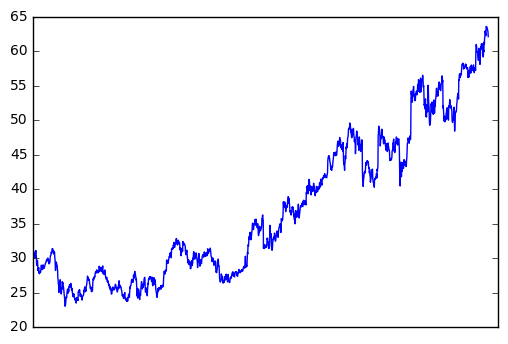

In [4]:
plt.plot(companyStock)
plt.xticks(())
plt.show()

In [5]:
# split into 70% train and 30% test sets
train_size = int(len(companyStock) * 0.7)
test_size = len(companyStock) - train_size
train, test = companyStock[0:train_size,:], companyStock[train_size:len(companyStock),:]
train.shape, test.shape

((1233, 1), (529, 1))

## 2 Methods and Assumptions
### 2.1 Time window (look_back)

In [6]:
# convert an array of values into a dataset matrix
# it creates a dataset where X is the number of passengers at a given time (t), 
# and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
# look_back is the setting for size of time window
# if look_back = 1, which means we are using nextday model
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1), (1231,), (527, 1), (527,))

### 2.2 Prediction Models (LR vs. LSTM)

### 2.3 Features (Adding Open,Volume)

## 3 Prediction Approaches
### 3.1 LR

In [8]:
# build the linear regression model
# train the model using the training sets
regr = linear_model.LinearRegression()
regr.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# make predictions
testPredict = regr.predict(testX)
# The coefficients
print('Coefficients:',regr.coef_)
# The mean squared error
testMSE = mean_squared_error(testPredict, testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [ 1.00052845]
Prediction MSE: 0.62026410


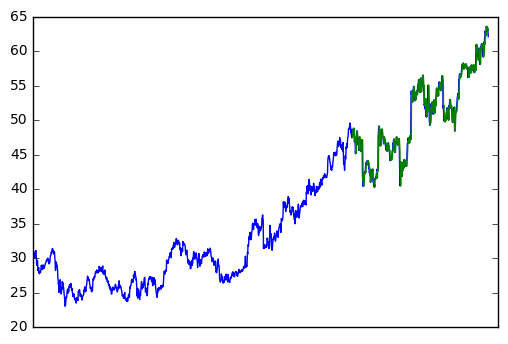

In [10]:
# shift test predictions for plotting
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

In [11]:
# rerun the model with time window of 5 days / 10 days
look_back = 5
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
regr = linear_model.LinearRegression()
regr.fit(trainX, trainY)

testPredict = regr.predict(testX)
print('Coefficients:',regr.coef_)
testMSE = mean_squared_error(testPredict, testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [ 0.03955124 -0.01977211 -0.02842844  0.00667846  1.0027982 ]
Prediction MSE: 0.62291668


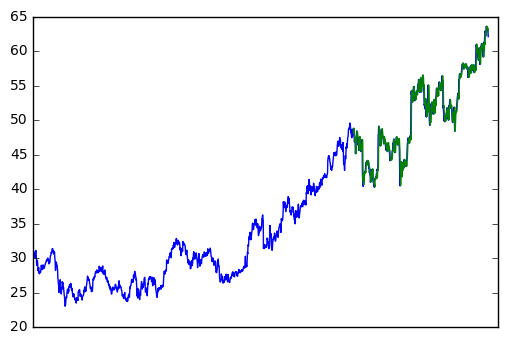

In [12]:
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

### 3.2 LSTM

In [13]:
# rescale the data to the range of 0-to-1 (normalizing data)
scaler = MinMaxScaler(feature_range=(0, 1))
companyStock = scaler.fit_transform(companyStock)
companyStock

array([[ 0.19551837],
       [ 0.19576454],
       [ 0.19108593],
       ..., 
       [ 0.98448664],
       [ 0.98227042],
       [ 0.96355575]], dtype=float32)

In [14]:
# split into 70% train and 30% test sets
train_size = int(len(companyStock) * 0.7)
test_size = len(companyStock) - train_size
train, test = companyStock[0:train_size,:], companyStock[train_size:len(companyStock),:]
train.shape, test.shape

((1233, 1), (529, 1))

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1), (1231,), (527, 1), (527,))

In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1, 1), (1231,), (527, 1, 1), (527,))

In [17]:
# build the LSTM
lstm = Sequential()
lstm.add(LSTM(4, input_shape=(1, look_back)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
# train the model
lstm.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
5s - loss: 0.0158
Epoch 2/10
4s - loss: 0.0012
Epoch 3/10
3s - loss: 1.3589e-04
Epoch 4/10
3s - loss: 1.3392e-04
Epoch 5/10
3s - loss: 1.3234e-04
Epoch 6/10
3s - loss: 1.3171e-04
Epoch 7/10
4s - loss: 1.2945e-04
Epoch 8/10
3s - loss: 1.3224e-04
Epoch 9/10
3s - loss: 1.2893e-04
Epoch 10/10
3s - loss: 1.3310e-04


In [19]:
# make predictions
testPredict = lstm.predict(testX)

# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
testMSE = mean_squared_error(testPredict[:,0],testY[0])
print("Prediction MSE: %.8f" % testMSE )

Prediction MSE: 0.93961613


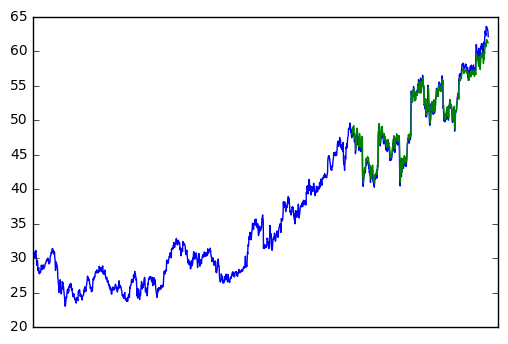

In [21]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

In [22]:
# rerun the model with time window of 5 days / 10 days
look_back = 5
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = 10,batch_size=1, verbose=2)

Epoch 1/10
5s - loss: 0.0054
Epoch 2/10
4s - loss: 2.8162e-04
Epoch 3/10
4s - loss: 2.5944e-04
Epoch 4/10
4s - loss: 2.4513e-04
Epoch 5/10
3s - loss: 2.2849e-04
Epoch 6/10
3s - loss: 2.1630e-04
Epoch 7/10
4s - loss: 2.0874e-04
Epoch 8/10
4s - loss: 1.9640e-04
Epoch 9/10
4s - loss: 1.8789e-04
Epoch 10/10
4s - loss: 1.9169e-04


In [23]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [24]:
testMSE = mean_squared_error(testPredict[:,0],testY[0])
print("Prediction MSE: %.8f" % testMSE )

Prediction MSE: 1.95490095


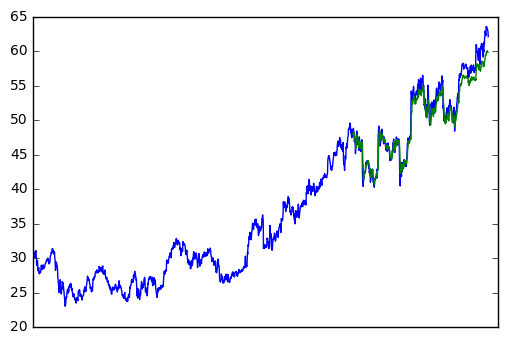

In [25]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

### 3.3 Adding features

In [26]:
openStock = company.open.values.astype('float32')
openStock = openStock.reshape(len(openStock), 1)
openStock

array([[ 30.62000084],
       [ 30.85000038],
       [ 30.87999916],
       ..., 
       [ 63.40000153],
       [ 62.86000061],
       [ 62.95999908]], dtype=float32)

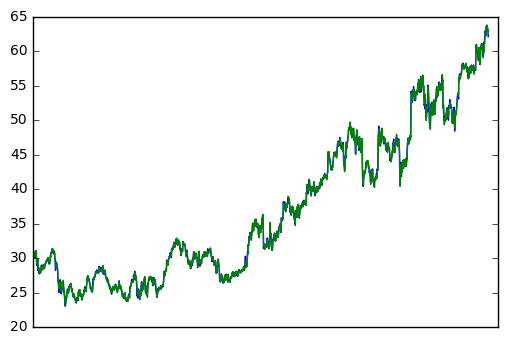

In [27]:
companyStock = scaler.inverse_transform(companyStock)
fig = plt.figure()
plt.plot(companyStock)
plt.plot(openStock)
plt.xticks(())
plt.show()

In [28]:
train_size = int(len(openStock) * 0.7)
test_size = len(openStock) - train_size

company.index = range(company.shape[0])
input1=pd.DataFrame(company.open[0:len(company.open)-1])
input2=pd.DataFrame(company.open[1:len(company.open)])
input3=pd.DataFrame(company.close[0:len(company.close)-1])
input4=pd.DataFrame(company.volume[0:len(company.close)-1])
input1.columns=['open1']
input2.columns=['open2']
input3.columns=['close1']
input4.columns=['volume1']
input2.index = range(input2.shape[0])
input_all = input1.join(input2)
input_all = input_all.join(input3).join(input4)
input_all.tail()

,open1,open2,close1,volume1
1756,63.840000,63.450001,63.549999,22176600
1757,63.450001,63.209999,63.240002,12403800
1758,63.209999,63.400002,63.279999,11763200
1759,63.400002,62.860001,62.990002,14653300
1760,62.860001,62.959999,62.900002,10250600


In [29]:
output_all = pd.DataFrame(company.close[1:len(company.close)])
output_all.index = range(output_all.shape[0])
output_all.tail()

,close
1756,63.240002
1757,63.279999
1758,62.990002
1759,62.900002
1760,62.139999


In [30]:
trainX, testX = input_all.ix[0:train_size,:], input_all.ix[train_size:len(openStock),:]
print(trainX.shape, testX.shape)
trainY, testY = output_all.ix[0:train_size,:], output_all.ix[train_size:len(openStock),:]
print(trainY.shape, testY.shape)
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

(1234, 4) (528, 4)
(1234, 1) (528, 1)


In [31]:
regr2 = linear_model.LinearRegression()
regr2.fit(trainX, trainY)
print('Coefficients:',regr2.coef_)
testMSE = mean_squared_error(regr2.predict(testX), testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [[ -2.07587312e-02   9.73854885e-01   4.59404276e-02  -1.24532962e-09]]
Prediction MSE: 0.32195103


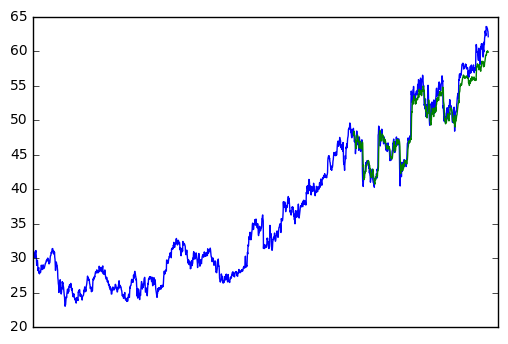

In [32]:
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

## 4 Findings

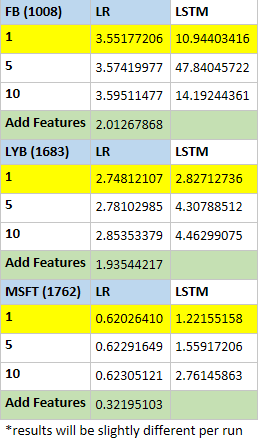

In [33]:
Image(filename='MSE.png') 

## 5 Next Step

## 6 Summary